<a href="https://colab.research.google.com/github/Waleed123/Kaggle_Competition_new/blob/main/Kagglecompetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt_kaggle

from google.colab import drive
drive.mount('/content/drive/')

# Load data
train_kaggle_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_kaggle_df = pd.read_csv('/content/drive/MyDrive/test.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True  
Pa

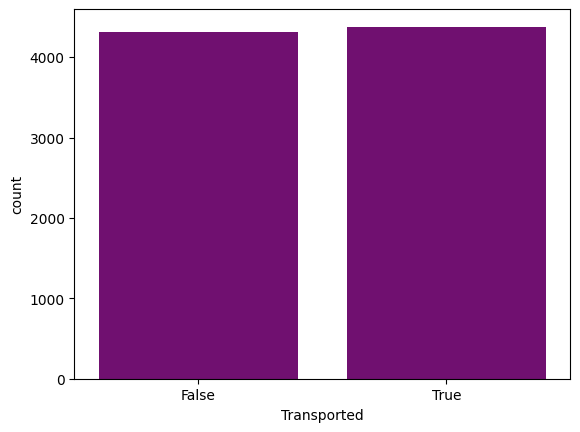

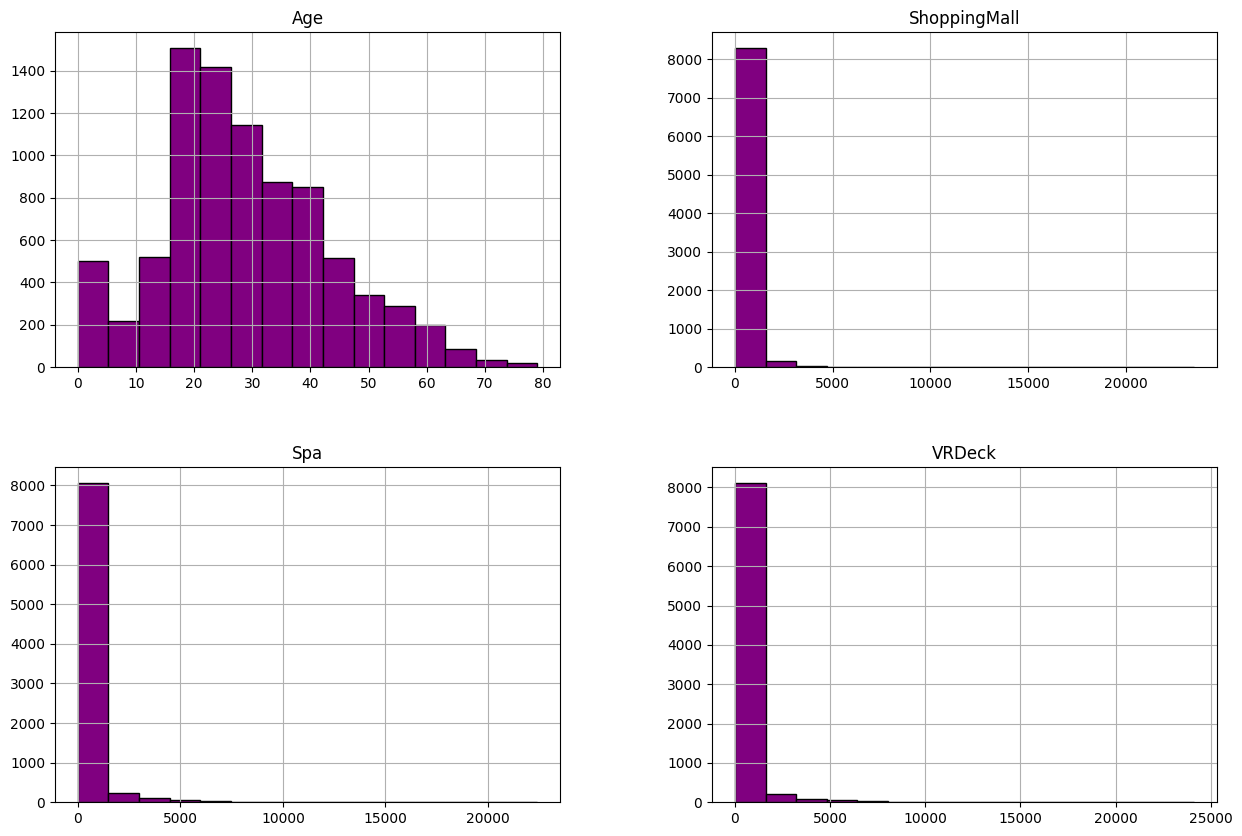

In [16]:
# Display the first few rows of the training dataset
print(train_kaggle_df.head())

# Store the 'PassengerId' column from the test dataset for future use
test_passenger_ids = test_kaggle_df['PassengerId']

# Check for missing values in the training dataset
print(train_kaggle_df.isnull().sum())

# Plot the distribution of the target variable 'Transported' using a count plot
sns.countplot(data=train_kaggle_df, x='Transported', color='purple')
plt_kaggle.show()

# Visualize the distribution of numeric features using histograms
numeric_features = ['Age', 'ShoppingMall', 'Spa', 'VRDeck']
train_kaggle_df[numeric_features].hist(bins=15, figsize=(15, 10), color='purple', edgecolor='black')
plt_kaggle.show()

In [17]:
# Drop the 'PassengerId', 'Name', 'Cabin', and 'VIP' columns from both the training and test datasets
train_kaggle_df.drop(['PassengerId', 'Name', 'Cabin', 'VIP'], axis=1, inplace=True)
test_kaggle_df.drop(['PassengerId', 'Name', 'Cabin', 'VIP'], axis=1, inplace=True)

# Define the categorical and numerical features
categorical_kaggle_features = ['HomePlanet', 'CryoSleep', 'Destination']
numeric_kaggle_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Initialize imputers for handling missing values in numerical and categorical features
numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Impute missing values in numerical features using the median
train_kaggle_df[numeric_kaggle_features] = numeric_imputer.fit_transform(train_kaggle_df[numeric_kaggle_features])
test_kaggle_df[numeric_kaggle_features] = numeric_imputer.transform(test_kaggle_df[numeric_kaggle_features])

# Impute missing values in categorical features using the most frequent value
train_kaggle_df[categorical_kaggle_features] = categorical_imputer.fit_transform(train_kaggle_df[categorical_kaggle_features])
test_kaggle_df[categorical_kaggle_features] = categorical_imputer.transform(test_kaggle_df[categorical_kaggle_features])

# Encode categorical variables into numerical values using LabelEncoder
label_encoders = {}
for feature in categorical_kaggle_features:
    label_encoders[feature] = LabelEncoder()
    train_kaggle_df[feature] = label_encoders[feature].fit_transform(train_kaggle_df[feature])
    test_kaggle_df[feature] = label_encoders[feature].transform(test_kaggle_df[feature])

# Scale numerical features using StandardScaler
scaler = StandardScaler()
train_kaggle_df[numeric_kaggle_features] = scaler.fit_transform(train_kaggle_df[numeric_kaggle_features])
test_kaggle_df[numeric_kaggle_features] = scaler.transform(test_kaggle_df[numeric_kaggle_features])


In [18]:
# Splitting the data
X = train_kaggle_df.drop('Transported', axis=1)
y = train_kaggle_df['Transported']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize base learners
rf_clf = RandomForestClassifier()
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


In [19]:
# Hyperparameter tuning
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

grid_search_xgb = GridSearchCV(estimator=xgb_clf, param_grid=param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_

# Initialize voting classifier with tuned models
voting_clf = VotingClassifier(estimators=[('rf', best_rf), ('xgb', best_xgb)], voting='soft')

# Train voting model
voting_clf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = voting_clf.predict(X_val)
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred)}")
print(classification_report(y_val, y_pred))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Validation Accuracy: 0.7878090856814262
              precision    recall  f1-score   support

       False       0.81      0.75      0.78       861
        True       0.77      0.83      0.80       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [20]:
# Predict on test data
test_predictions = voting_clf.predict(test_kaggle_df)

# Convert 1 and 0 to TRUE and FALSE
test_predictions = ['True' if x == 1 else 'False' for x in test_predictions]

# Prepare submission file
submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Transported': test_predictions
})
submission.to_csv('/content/drive/MyDrive/result.csv', index=False)

# Display submission
print(submission.head())

  PassengerId Transported
0     0013_01        True
1     0018_01       False
2     0019_01        True
3     0021_01        True
4     0023_01        True


In [ ]:
# 0.79167 kaggle result

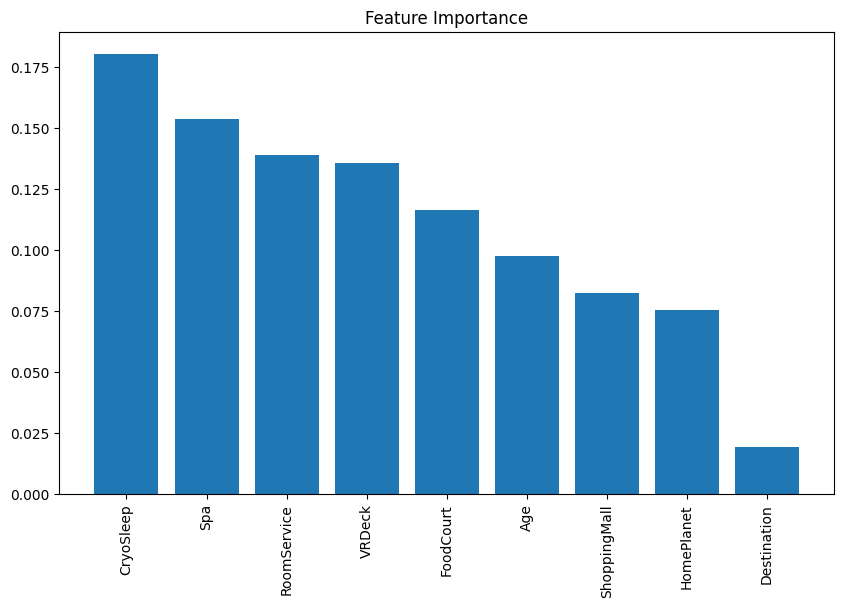

Misclassified instances analysis
       HomePlanet   CryoSleep  Destination         Age  RoomService  \
count  369.000000  369.000000   369.000000  369.000000   369.000000   
mean     0.422764    0.322493     1.596206   -0.014479    -0.110470   
std      0.740976    0.468065     0.708709    0.996079     0.649322   
min      0.000000    0.000000     0.000000   -2.007610    -0.333105   
25%      0.000000    0.000000     1.000000   -0.612966    -0.333105   
50%      0.000000    0.000000     2.000000   -0.194573    -0.333105   
75%      1.000000    1.000000     2.000000    0.642213    -0.286169   
max      2.000000    1.000000     2.000000    3.082840     4.938810   

        FoodCourt  ShoppingMall         Spa      VRDeck  
count  369.000000    369.000000  369.000000  369.000000  
mean    -0.029047      0.050953   -0.173479   -0.118914  
std      0.723215      0.691134    0.323946    0.430762  
min     -0.281027     -0.283579   -0.270626   -0.263003  
25%     -0.281027     -0.283579   -0.

In [21]:
# Feature importance
importances = np.mean([tree.feature_importances_ for tree in voting_clf.named_estimators_['rf']], axis=0)
indices = np.argsort(importances)[::-1]
features = X.columns

# Plot feature importance
plt_kaggle.figure(figsize=(10, 6))
plt_kaggle.title("Feature Importance")
plt_kaggle.bar(range(X.shape[1]), importances[indices], align="center")
plt_kaggle.xticks(range(X.shape[1]), features[indices], rotation=90)
plt_kaggle.show()

# Analyzing misclassified instances
misclassified = X_val[y_val != y_pred]
print("Misclassified instances analysis")
print(misclassified.describe())